# MBTI Prediction - Strategy 1

The **Myers–Briggs Type Indicator (MBTI)** is an introspective self-report questionnaire indicating differing psychological preferences in how people perceive the world and make decisions. The test attempts to assign four categories:
- introversion (I) or extraversion (E),
- sensing (S) or intuition (N), 
- thinking (T) or feeling (F), 
- judging (J) or perceiving (P).

One letter from each category is taken to produce a four-letter test result, like "INFJ" or "ENFP".

Source : https://en.wikipedia.org/wiki/Myers%E2%80%93Briggs_Type_Indicator
<br>Data source : https://www.kaggle.com/datasnaek/mbti-type

**Objective:** Predict the MBTI type with few sentences.

## Libraries

In [17]:
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from wordcloud import WordCloud

## Data import

In [2]:
df = pd.read_csv('../mbti_data.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## Data exploration

**Let's quickly analyze data quality.**

In [3]:
df.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'Every single religious person picks and choos...
freq,1832,1


The quality seems good, indeed: 
- no missing cells
- all MBTI types considered

**Let's see the distribution of the column 'type'.**

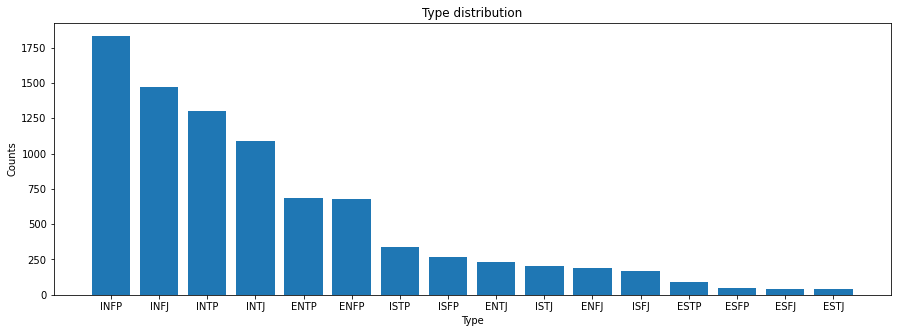

In [4]:
type_dist = df['type'].value_counts().rename_axis('types').reset_index(name='counts')

plt.figure(figsize=(15,5))
plt.bar(range(len(type_dist)), type_dist['counts'])
plt.xticks(range(len(type_dist)), type_dist['types'])
plt.xlabel('Type')
plt.ylabel('Counts')
plt.title('Type distribution')
plt.show()

The column "type" is unbalanced. 
<br>We will therefore use the metric "F1-score" instead of "accuracy" to evaluate our future classification model.

**Let's identify the most representative (most frequent) words of each MBTI type.**

First, we preprocess the posts.

In [5]:
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()

def preprocessing(text, stemming_on=False, stop_words=stop_words, porter_stemmer=porter_stemmer):
    text = text.lower()                                          # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)                  # Noise removal (regex to remove punctuations)
    text = text.strip()                                          # Noise removal (extra spaces)
    words = text.split()                                         # Split sentence into list of words
    words = [w for w in words if not w in stop_words]            # Stopwords removal
    if(stemming_on):
        words = [porter_stemmer.stem(word) for word in words]    # Replace the word by its stem
    return words

In [6]:
df['posts_preproc'] = df['posts'].apply(lambda row: preprocessing(row, stemming_on=True))

In [7]:
df.head()

,type,posts,posts_preproc
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"[http, www, youtub, com, watch, v, qsxhcwe3krw..."
1,ENTP,'I'm finding the lack of me in these posts ver...,"[find, lack, post, alarm, sex, bore, posit, of..."
2,INTP,'Good one _____ https://www.youtube.com/wat...,"[good, one, http, www, youtub, com, watch, v, ..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","[dear, intp, enjoy, convers, day, esoter, gab,..."
4,ENTJ,'You're fired.|||That's another silly misconce...,"[fire, anoth, silli, misconcept, approach, log..."


Now we group all posts that are the same MBTI type.

In [8]:
df_grouped = df.groupby('type')['posts_preproc'].apply(list).reset_index(name='posts_grouped')
df_grouped['posts_grouped'] = df_grouped['posts_grouped'].apply(lambda row: [y for x in row for y in x]) # Flatten list
df_grouped

,type,posts_grouped
0,ENFJ,"[http, www, youtub, com, watch, v, plaaikvhvz,..."
1,ENFP,"[want, go, trip, without, stay, behind, option..."
2,ENTJ,"[fire, anoth, silli, misconcept, approach, log..."
3,ENTP,"[find, lack, post, alarm, sex, bore, posit, of..."
4,ESFJ,"[esfj, origin, mistyp, nfp, think, increasingl..."
5,ESFP,"[edit, forgot, board, current, read, artemi, f..."
6,ESTJ,"[catch, 22, although, quit, terribl, estj, fi,..."
7,ESTP,"[splinter, cell, blacklist, xbox, 360, estp, g..."
8,INFJ,"[http, www, youtub, com, watch, v, qsxhcwe3krw..."
9,INFP,"[think, agre, person, consid, alpha, beta, fox..."


We select the 15 most frequent words for each type.

In [9]:
df_grouped['most_frequent_words_v1'] = df_grouped['posts_grouped'].apply(lambda row: Counter(row).most_common(15))
df_grouped

,type,posts_grouped,most_frequent_words_v1
0,ENFJ,"[http, www, youtub, com, watch, v, plaaikvhvz,...","[(like, 1781), (think, 1410), (peopl, 1192), (..."
1,ENFP,"[want, go, trip, without, stay, behind, option...","[(like, 6607), (think, 4686), (enfp, 4231), (p..."
2,ENTJ,"[fire, anoth, silli, misconcept, approach, log...","[(like, 1882), (think, 1492), (entj, 1267), (p..."
3,ENTP,"[find, lack, post, alarm, sex, bore, posit, of...","[(like, 5911), (think, 4626), (entp, 3899), (p..."
4,ESFJ,"[esfj, origin, mistyp, nfp, think, increasingl...","[(like, 416), (esfj, 401), (think, 362), (peop..."
5,ESFP,"[edit, forgot, board, current, read, artemi, f...","[(like, 392), (think, 295), (peopl, 226), (kno..."
6,ESTJ,"[catch, 22, although, quit, terribl, estj, fi,...","[(like, 299), (think, 273), (estj, 240), (peop..."
7,ESTP,"[splinter, cell, blacklist, xbox, 360, estp, g...","[(like, 820), (think, 577), (estp, 565), (get,..."
8,INFJ,"[http, www, youtub, com, watch, v, qsxhcwe3krw...","[(like, 13081), (think, 10364), (peopl, 8657),..."
9,INFP,"[think, agre, person, consid, alpha, beta, fox...","[(like, 17259), (think, 13133), (peopl, 10563)..."


In [10]:
for i in range(len(df_grouped)):
    print(f"{df_grouped['type'][i]}: \n{df_grouped['most_frequent_words_v1'][i]} \n")

ENFJ: 
[('like', 1781), ('think', 1410), ('peopl', 1192), ('enfj', 1147), ('feel', 1112), ('know', 1013), ('get', 942), ('realli', 901), ('one', 881), ('thing', 827), ('love', 796), ('would', 787), ('time', 770), ('person', 701), ('friend', 696)] 

ENFP: 
[('like', 6607), ('think', 4686), ('enfp', 4231), ('peopl', 3742), ('know', 3392), ('get', 3283), ('feel', 3238), ('one', 3232), ('realli', 3124), ('thing', 2927), ('love', 2919), ('time', 2722), ('would', 2675), ('go', 2302), ('make', 2278)] 

ENTJ: 
[('like', 1882), ('think', 1492), ('entj', 1267), ('peopl', 1239), ('get', 1096), ('one', 1054), ('would', 977), ('know', 958), ('type', 937), ('thing', 857), ('time', 812), ('make', 803), ('person', 788), ('feel', 776), ('say', 738)] 

ENTP: 
[('like', 5911), ('think', 4626), ('entp', 3899), ('peopl', 3739), ('one', 3277), ('get', 3129), ('know', 3002), ('would', 2685), ('thing', 2684), ('realli', 2590), ('time', 2402), ('type', 2260), ('go', 2182), ('make', 2161), ('say', 2145)] 

ESFJ

We notice that several words such as "like" and "think" are present for each type. Let's remove these words because they do not provide information for the next steps.

In [11]:
words_to_remove = [
    'like',
    'think',
    'peopl',
    'get',
    'know',
    'would',
    'realli',
    'time',
    'one',
    'well',
    'com',
    'www',
    'much',
    'say',
    'good',
    'someth',
    'thing',
    'way',
    'see',
    'want',
    'also',
    'type',
    'alway'
]

df_grouped['posts_grouped_filtered'] = df_grouped['posts_grouped'].apply(lambda row: [w for w in row if not w in words_to_remove])

In [12]:
df_grouped['most_frequent_words_v2'] = df_grouped['posts_grouped_filtered'].apply(lambda row: Counter(row).most_common(15))
df_grouped

,type,posts_grouped,most_frequent_words_v1,posts_grouped_filtered,most_frequent_words_v2
0,ENFJ,"[http, www, youtub, com, watch, v, plaaikvhvz,...","[(like, 1781), (think, 1410), (peopl, 1192), (...","[http, youtub, watch, v, plaaikvhvz, 51, went,...","[(enfj, 1147), (feel, 1112), (love, 796), (per..."
1,ENFP,"[want, go, trip, without, stay, behind, option...","[(like, 6607), (think, 4686), (enfp, 4231), (p...","[go, trip, without, stay, behind, option, beli...","[(enfp, 4231), (feel, 3238), (love, 2919), (go..."
2,ENTJ,"[fire, anoth, silli, misconcept, approach, log...","[(like, 1882), (think, 1492), (entj, 1267), (p...","[fire, anoth, silli, misconcept, approach, log...","[(entj, 1267), (make, 803), (person, 788), (fe..."
3,ENTP,"[find, lack, post, alarm, sex, bore, posit, of...","[(like, 5911), (think, 4626), (entp, 3899), (p...","[find, lack, post, alarm, sex, bore, posit, of...","[(entp, 3899), (go, 2182), (make, 2161), (feel..."
4,ESFJ,"[esfj, origin, mistyp, nfp, think, increasingl...","[(like, 416), (esfj, 401), (think, 362), (peop...","[esfj, origin, mistyp, nfp, increasingli, comm...","[(esfj, 401), (feel, 221), (love, 170), (make,..."
5,ESFP,"[edit, forgot, board, current, read, artemi, f...","[(like, 392), (think, 295), (peopl, 226), (kno...","[edit, forgot, board, current, read, artemi, f...","[(esfp, 184), (feel, 154), (person, 148), (htt..."
6,ESTJ,"[catch, 22, although, quit, terribl, estj, fi,...","[(like, 299), (think, 273), (estj, 240), (peop...","[catch, 22, although, quit, terribl, estj, fi,...","[(estj, 240), (person, 133), (feel, 129), (go,..."
7,ESTP,"[splinter, cell, blacklist, xbox, 360, estp, g...","[(like, 820), (think, 577), (estp, 565), (get,...","[splinter, cell, blacklist, xbox, 360, estp, g...","[(estp, 565), (go, 312), (http, 287), (make, 2..."
8,INFJ,"[http, www, youtub, com, watch, v, qsxhcwe3krw...","[(like, 13081), (think, 10364), (peopl, 8657),...","[http, youtub, watch, v, qsxhcwe3krw, http, 41...","[(infj, 8170), (feel, 7842), (person, 4907), (..."
9,INFP,"[think, agre, person, consid, alpha, beta, fox...","[(like, 17259), (think, 13133), (peopl, 10563)...","[agre, person, consid, alpha, beta, foxtrot, l...","[(feel, 10242), (infp, 9423), (http, 6862), (l..."


In [13]:
for i in range(len(df_grouped)):
    print(f"{df_grouped['type'][i]}: \n{df_grouped['most_frequent_words_v2'][i]} \n")

ENFJ: 
[('enfj', 1147), ('feel', 1112), ('love', 796), ('person', 701), ('friend', 696), ('make', 673), ('go', 664), ('thank', 515), ('http', 503), ('tri', 477), ('someon', 447), ('need', 432), ('lot', 411), ('use', 401), ('work', 379)] 

ENFP: 
[('enfp', 4231), ('feel', 3238), ('love', 2919), ('go', 2302), ('make', 2278), ('friend', 2241), ('person', 2061), ('http', 1694), ('thank', 1642), ('lot', 1611), ('tri', 1548), ('watch', 1380), ('even', 1354), ('look', 1325), ('use', 1301)] 

ENTJ: 
[('entj', 1267), ('make', 803), ('person', 788), ('feel', 776), ('go', 697), ('http', 610), ('work', 529), ('use', 506), ('tri', 501), ('friend', 474), ('need', 457), ('find', 455), ('love', 452), ('lot', 438), ('intj', 437)] 

ENTP: 
[('entp', 3899), ('go', 2182), ('make', 2161), ('feel', 2011), ('person', 1922), ('friend', 1689), ('http', 1638), ('use', 1603), ('love', 1528), ('tri', 1487), ('lot', 1375), ('work', 1309), ('actual', 1277), ('even', 1270), ('find', 1251)] 

ESFJ: 
[('esfj', 401), (

Finally, we plot the result.

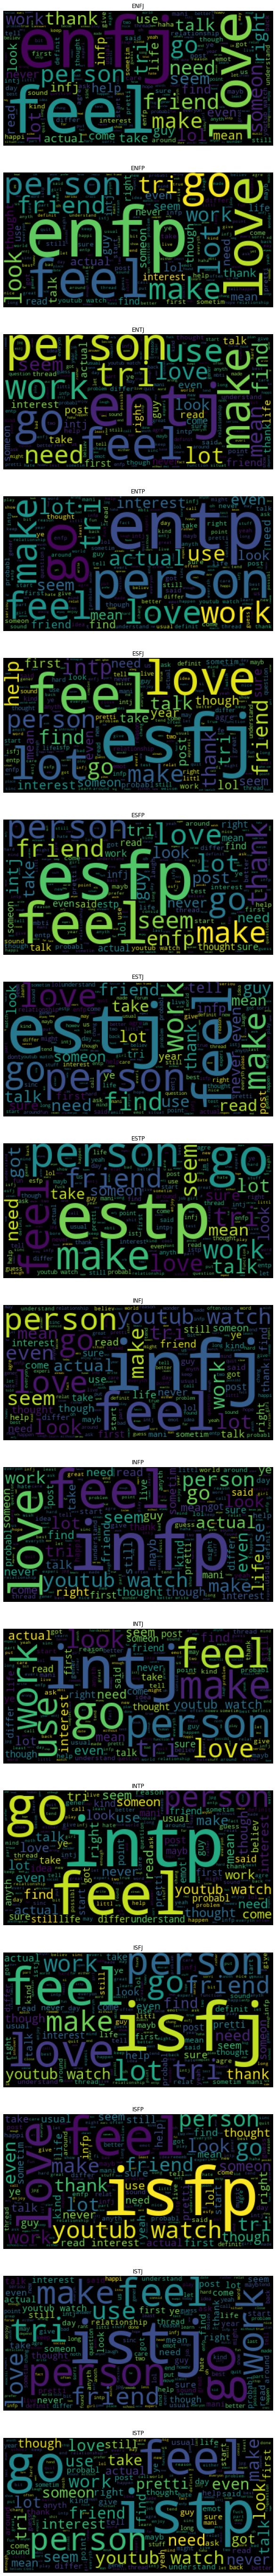

In [14]:
fig, ax = plt.subplots(len(df_grouped), figsize=(100,100))

for i in range(len(df_grouped)):
    wordcloud = WordCloud().generate(" ".join(df_grouped.loc[i, 'posts_grouped_filtered']))
    ax[i].imshow(wordcloud)
    ax[i].set_title(df_grouped.loc[i, 'type'])
    ax[i].axis("off")

## Prediction analysis

**Data preprocessing**

We remove the words identified as useless in the initial dataframe.

In [15]:
df['posts_preproc_filtered'] = df['posts_preproc'].apply(lambda row: [w for w in row if not w in words_to_remove])
df['posts_final'] = df['posts_preproc_filtered'].apply(lambda row: ' '.join(row))
df.head()

,type,posts,posts_preproc,posts_preproc_filtered,posts_final
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"[http, www, youtub, com, watch, v, qsxhcwe3krw...","[http, youtub, watch, v, qsxhcwe3krw, http, 41...",http youtub watch v qsxhcwe3krw http 41 media ...
1,ENTP,'I'm finding the lack of me in these posts ver...,"[find, lack, post, alarm, sex, bore, posit, of...","[find, lack, post, alarm, sex, bore, posit, of...",find lack post alarm sex bore posit often exam...
2,INTP,'Good one _____ https://www.youtube.com/wat...,"[good, one, http, www, youtub, com, watch, v, ...","[http, youtub, watch, v, fhigbolffgw, cours, b...",http youtub watch v fhigbolffgw cours bless cu...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","[dear, intp, enjoy, convers, day, esoter, gab,...","[dear, intp, enjoy, convers, day, esoter, gab,...",dear intp enjoy convers day esoter gab natur u...
4,ENTJ,'You're fired.|||That's another silly misconce...,"[fire, anoth, silli, misconcept, approach, log...","[fire, anoth, silli, misconcept, approach, log...",fire anoth silli misconcept approach logic go ...


**Vectorization**

We benchmark 2 methods:
- CountVectorizer
- TfidfVectorizer

In [18]:
corpus = df['posts_final']
y = df['type']

c_vectorizer = CountVectorizer()
ti_vectorizer = TfidfVectorizer()

In [19]:
c_X = c_vectorizer.fit_transform(corpus)
ti_X = ti_vectorizer.fit_transform(corpus)

In [20]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, y, test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, y, test_size=0.2, random_state=14)

**Prediction**

*Configuration 1: CountVectorizer + LinearSVC*

In [21]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

              precision    recall  f1-score   support

        ENFJ       0.47      0.20      0.29        44
        ENFP       0.56      0.57      0.56       122
        ENTJ       0.67      0.48      0.56        50
        ENTP       0.53      0.62      0.57       128
        ESFJ       0.33      0.20      0.25         5
        ESFP       0.50      0.38      0.43         8
        ESTJ       0.50      0.29      0.36         7
        ESTP       0.62      0.53      0.57        15
        INFJ       0.61      0.65      0.63       274
        INFP       0.69      0.71      0.70       391
        INTJ       0.56      0.57      0.57       221
        INTP       0.63      0.63      0.63       286
        ISFJ       0.45      0.48      0.47        29
        ISFP       0.35      0.30      0.32        47
        ISTJ       0.49      0.42      0.45        40
        ISTP       0.53      0.53      0.53        68

    accuracy                           0.60      1735
   macro avg       0.53   

c:\users\anthony\documents\machine-learning\mbti-prediction\dev-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


*Configuration 2: TfidfVectorizer + LinearSVC*

In [57]:
ti_clf = LinearSVC(random_state=14)
ti_clf.fit(ti_X_train, ti_y_train)
ti_y_pred = ti_clf.predict(ti_X_test)
print(classification_report(ti_y_test, ti_y_pred))

              precision    recall  f1-score   support

        ENFJ       0.64      0.20      0.31        44
        ENFP       0.66      0.63      0.65       122
        ENTJ       0.76      0.52      0.62        50
        ENTP       0.73      0.68      0.70       128
        ESFJ       0.25      0.20      0.22         5
        ESFP       1.00      0.12      0.22         8
        ESTJ       1.00      0.43      0.60         7
        ESTP       0.62      0.53      0.57        15
        INFJ       0.65      0.72      0.68       274
        INFP       0.73      0.86      0.79       391
        INTJ       0.65      0.65      0.65       221
        INTP       0.72      0.74      0.73       286
        ISFJ       0.56      0.52      0.54        29
        ISFP       0.68      0.36      0.47        47
        ISTJ       0.79      0.47      0.59        40
        ISTP       0.65      0.68      0.66        68

    accuracy                           0.69      1735
   macro avg       0.69   

*Configuration 3: CountVectorizer + MultinomialNB*

In [59]:
c_clf = MultinomialNB()
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred, zero_division=0))

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        44
        ENFP       1.00      0.01      0.02       122
        ENTJ       0.00      0.00      0.00        50
        ENTP       0.43      0.02      0.04       128
        ESFJ       0.00      0.00      0.00         5
        ESFP       0.00      0.00      0.00         8
        ESTJ       0.00      0.00      0.00         7
        ESTP       0.00      0.00      0.00        15
        INFJ       0.35      0.64      0.45       274
        INFP       0.40      0.87      0.55       391
        INTJ       0.68      0.19      0.30       221
        INTP       0.51      0.55      0.53       286
        ISFJ       0.00      0.00      0.00        29
        ISFP       0.00      0.00      0.00        47
        ISTJ       0.00      0.00      0.00        40
        ISTP       0.00      0.00      0.00        68

    accuracy                           0.41      1735
   macro avg       0.21   

*Configuration 4: TfidfVectorizer + MultinomialNB*

In [61]:
ti_clf = MultinomialNB()
ti_clf.fit(ti_X_train, ti_y_train)
ti_y_pred = ti_clf.predict(ti_X_test)
print(classification_report(ti_y_test, ti_y_pred, zero_division=0))

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        44
        ENFP       0.00      0.00      0.00       122
        ENTJ       0.00      0.00      0.00        50
        ENTP       0.00      0.00      0.00       128
        ESFJ       0.00      0.00      0.00         5
        ESFP       0.00      0.00      0.00         8
        ESTJ       0.00      0.00      0.00         7
        ESTP       0.00      0.00      0.00        15
        INFJ       0.00      0.00      0.00       274
        INFP       0.23      1.00      0.37       391
        INTJ       0.00      0.00      0.00       221
        INTP       0.00      0.00      0.00       286
        ISFJ       0.00      0.00      0.00        29
        ISFP       0.00      0.00      0.00        47
        ISTJ       0.00      0.00      0.00        40
        ISTP       0.00      0.00      0.00        68

    accuracy                           0.23      1735
   macro avg       0.01   

*Configuration 5: CountVectorizer + LogisticRegression*

In [62]:
c_clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

              precision    recall  f1-score   support

        ENFJ       0.50      0.25      0.33        44
        ENFP       0.57      0.58      0.58       122
        ENTJ       0.69      0.54      0.61        50
        ENTP       0.59      0.66      0.63       128
        ESFJ       0.14      0.20      0.17         5
        ESFP       0.43      0.38      0.40         8
        ESTJ       0.43      0.43      0.43         7
        ESTP       0.50      0.60      0.55        15
        INFJ       0.66      0.66      0.66       274
        INFP       0.71      0.74      0.73       391
        INTJ       0.61      0.59      0.60       221
        INTP       0.67      0.66      0.66       286
        ISFJ       0.52      0.55      0.53        29
        ISFP       0.41      0.38      0.40        47
        ISTJ       0.58      0.62      0.60        40
        ISTP       0.59      0.62      0.60        68

    accuracy                           0.63      1735
   macro avg       0.54   

c:\users\anthony\documents\machine-learning\mbti-prediction\dev-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



*Configuration 6: TfidfVectorizer + LogisticRegression*

In [63]:
ti_clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=14)
ti_clf.fit(ti_X_train, ti_y_train)
ti_y_pred = ti_clf.predict(ti_X_test)
print(classification_report(ti_y_test, ti_y_pred))

              precision    recall  f1-score   support

        ENFJ       0.54      0.50      0.52        44
        ENFP       0.65      0.61      0.63       122
        ENTJ       0.59      0.66      0.62        50
        ENTP       0.70      0.70      0.70       128
        ESFJ       0.14      0.20      0.17         5
        ESFP       0.20      0.25      0.22         8
        ESTJ       0.50      0.57      0.53         7
        ESTP       0.42      0.67      0.51        15
        INFJ       0.81      0.67      0.74       274
        INFP       0.79      0.77      0.78       391
        INTJ       0.71      0.68      0.70       221
        INTP       0.77      0.80      0.78       286
        ISFJ       0.44      0.66      0.53        29
        ISFP       0.57      0.62      0.59        47
        ISTJ       0.59      0.72      0.65        40
        ISTP       0.63      0.76      0.69        68

    accuracy                           0.71      1735
   macro avg       0.57   

In [64]:
ti_clf = LogisticRegression(class_weight='balanced', multi_class='ovr', max_iter=1000, random_state=14)
ti_clf.fit(ti_X_train, ti_y_train)
ti_y_pred = ti_clf.predict(ti_X_test)
print(classification_report(ti_y_test, ti_y_pred))

              precision    recall  f1-score   support

        ENFJ       0.69      0.41      0.51        44
        ENFP       0.65      0.61      0.63       122
        ENTJ       0.71      0.58      0.64        50
        ENTP       0.69      0.70      0.69       128
        ESFJ       0.17      0.20      0.18         5
        ESFP       0.67      0.25      0.36         8
        ESTJ       0.60      0.43      0.50         7
        ESTP       0.56      0.67      0.61        15
        INFJ       0.73      0.71      0.72       274
        INFP       0.76      0.82      0.79       391
        INTJ       0.70      0.68      0.69       221
        INTP       0.74      0.81      0.77       286
        ISFJ       0.45      0.52      0.48        29
        ISFP       0.65      0.51      0.57        47
        ISTJ       0.78      0.70      0.74        40
        ISTP       0.68      0.71      0.69        68

    accuracy                           0.72      1735
   macro avg       0.64   

## Conclusion
The best results are achieved with the **TfidfVectorizer + LogisticRegression** configuration. We notice that for well represented classes, the results are quite good. However, for the less represented classes, the results are less good and less reliable. I therefore propose a new approach strategy which consists in creating a model to predict each class independently, i.e. 4 binary classification models. I invite you to redirect you to the **Strategy 2** notebook.